In [1]:
!pip install -r ../requirements.txt

# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

# REPRODUCIBILITY

In [3]:
def set_seed(seed=42):
    """
    Set all relevant random seeds for reproducibility.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# DEVICE CONFIGURATION

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# DATA LOADING AND TRANSFORMS

In [5]:
#apply data augmentations and normalisation CIFAR-10 training data
train_transform = transforms.Compose([
    # Cropping
    transforms.RandomCrop(32, padding=4),
    # Flipping
    transforms.RandomHorizontalFlip(),
    # Rotation
    transforms.RandomRotation(15), 
    # Color Jitter
    transforms.ColorJitter(          
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    # normalisation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
    #Erasing
    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.33),
        ratio=(0.3, 3.3),
        value=0
    )
])

# Normalise Test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=False,
    download=True,
    transform=test_transform
)

# We can split off a validation set from the training data
val_size = 5000
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Training Data: {len(train_data)}")
print(f"Length of Validation Data: {len(val_data)}")
print(f"Length of Test Data: {len(test_dataset)}")

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Length of Training Data: 45000
Length of Validation Data: 5000
Length of Test Data: 10000


# CNN MODEL (VGG16-INSPIRED)

In [6]:
class CNN_model(nn.Module):
    """
    A simplified VGG-like network for CIFAR-10 classification:
      - 2 Conv layers, BatchNorm, MaxPool, Dropout
      - Repeat blocks with increasing channels: 32 -> 64 -> 128 -> 256
      - Fully connected layer for classification into 10 classes
    """
    def __init__(self, num_classes=10):
        super(CNN_model, self).__init__()

        # Block 1: 32 filters
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        # Block 2: 64 filters
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Block 3: 128 filters
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )

        # Block 4: 256 filters
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )


        # Classification head
        # After the 4th block, the spatial dimension is 2x2 (for CIFAR-10: 32 -> 16 -> 8 -> 4 -> 2).
        self.classifier = nn.Sequential(
            # Flatten
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    # confirm the spatial dimension is 2x2
    def forward(self, x):
        x = self.block1(x)        # [B, 32, 16, 16]
        x = self.block2(x)        # [B, 64, 8, 8]
        x = self.block3(x)        # [B, 128, 4, 4]
        x = self.block4(x)        # [B, 256, 2, 2]
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)    # [B, 10]
        return x


# EVALUATION METRICS AND TRAIN/VALIDATION LOOP

In [7]:
def accuracy(outputs, labels):
    """
    Compute the batch accuracy.
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    """
    Evaluate the model on the validation set.
    Returns average loss and accuracy.
    """
    model.eval()
    losses = []
    accs = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss.item())
        accs.append(acc.item())

    val_loss = np.mean(losses)
    val_acc  = np.mean(accs)
    return val_loss, val_acc

In [8]:
# fit with early stopping
def fit(
    model,
    train_loader,
    val_loader,
    epochs=250,
    patience_lr=10,     # patience for ReduceLROnPlateau
    patience_es=20,     # patience for EarlyStopping
    factor=0.5,         # LR reduction factor
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=None
):
    """
    Train the model with ReduceLROnPlateau and EarlyStopping.

    Arguments:
    ----------
    model           : The PyTorch model to train.
    train_loader    : DataLoader for training data.
    val_loader      : DataLoader for validation data.
    epochs          : Max number of epochs to run.
    patience_lr     : # of epochs with no val_loss improvement before reducing LR.
    patience_es     : # of epochs with no val_loss improvement before early stopping.
    factor          : Factor by which to reduce LR on plateau (e.g. 0.5 = half).
    optimizer_cls   : Optimizer class (e.g., torch.optim.Adam).
    optimizer_kwargs: Dictionary of parameters for the optimizer.

    Returns:
    --------
    history : List of dicts with training info per epoch.
    """

    if optimizer_kwargs is None:
        optimizer_kwargs = {"lr": 1e-3, "weight_decay": 0.0}

    # Instantiate the optimizer
    optimizer = optimizer_cls(model.parameters(), **optimizer_kwargs)

    # Scheduler: reduces LR when val_loss has stopped improving
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor,
                                  patience=patience_lr, verbose=True)

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0  # For early stopping

    history = []

    for epoch in range(1, epochs+1):
        start_time = datetime.now()
        model.train()
        train_losses = []
        train_accs = []

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            acc = accuracy(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append(acc.item())

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader)

        # Mean metrics for this epoch
        train_loss_epoch = np.mean(train_losses)
        train_acc_epoch  = np.mean(train_accs)

        # Check if validation loss improved
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Print epoch results
        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {train_loss_epoch:.4f}, "
              f"Train Acc: {train_acc_epoch:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, "
              f"Time: {datetime.now() - start_time}")

        # Append to history
        history.append({
            'epoch': epoch,
            'train_loss': train_loss_epoch,
            'train_acc': train_acc_epoch,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        # Step the scheduler
        # (it expects a metric to monitor, here we use val_loss)
        scheduler.step(val_loss)

        # Check early stopping condition
        if epochs_no_improve >= patience_es:
            print(f"EarlyStopping triggered! No improvement for {patience_es} epochs.")
            break

    # Restore best weights
    model.load_state_dict(best_model_wts)
    return history

# TESTING & PLOT FUNCTION

In [9]:
@torch.no_grad()
def test_model(model, test_loader):
    """
    Evaluate the model on the test dataset.
    """
    model.eval()
    losses = []
    accs = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss.item())
        accs.append(acc.item())

    test_loss = np.mean(losses)
    test_acc  = np.mean(accs)
    return test_loss, test_acc

def plot_history(hist):
    """
    Plot training and validation loss/accuracy curves over epochs.
    """
    epochs_list = [x['epoch'] for x in hist]

    train_loss = [x['train_loss'] for x in hist]
    val_loss   = [x['val_loss'] for x in hist]
    train_acc  = [x['train_acc'] for x in hist]
    val_acc    = [x['val_acc'] for x in hist]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    # Loss subplot
    ax1.plot(epochs_list, train_loss, label='Train Loss')
    ax1.plot(epochs_list, val_loss, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.legend()

    # Accuracy subplot
    ax2.plot(epochs_list, train_acc, label='Train Acc')
    ax2.plot(epochs_list, val_acc, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.legend()

    plt.show()

# HYPERPARAMETER SETUP & TRAINING

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30] Train Loss: 1.8144, Train Acc: 0.3272, Val Loss: 1.4970, Val Acc: 0.4596, Time: 0:00:31.655489
Epoch [2/30] Train Loss: 1.4997, Train Acc: 0.4603, Val Loss: 1.3513, Val Acc: 0.5260, Time: 0:00:28.826132
Epoch [3/30] Train Loss: 1.3283, Train Acc: 0.5301, Val Loss: 1.1956, Val Acc: 0.5775, Time: 0:00:28.957752
Epoch [4/30] Train Loss: 1.2231, Train Acc: 0.5708, Val Loss: 1.0858, Val Acc: 0.6197, Time: 0:00:29.227357
Epoch [5/30] Train Loss: 1.1411, Train Acc: 0.6021, Val Loss: 1.0398, Val Acc: 0.6404, Time: 0:00:29.113923
Epoch [6/30] Train Loss: 1.0774, Train Acc: 0.6253, Val Loss: 0.9547, Val Acc: 0.6590, Time: 0:00:29.321222
Epoch [7/30] Train Loss: 1.0364, Train Acc: 0.6433, Val Loss: 0.8959, Val Acc: 0.6889, Time: 0:00:29.414744
Epoch [8/30] Train Loss: 0.9988, Train Acc: 0.6589, Val Loss: 0.9154, Val Acc: 0.6775, Time: 0:00:29.232304
Epoch [9/30] Train Loss: 0.9743, Train Acc: 0.6691, Val Loss: 0.8581, Val Acc: 0.7006, Time: 0:00:29.399829
Epoch [10/30] Train Loss: 0.

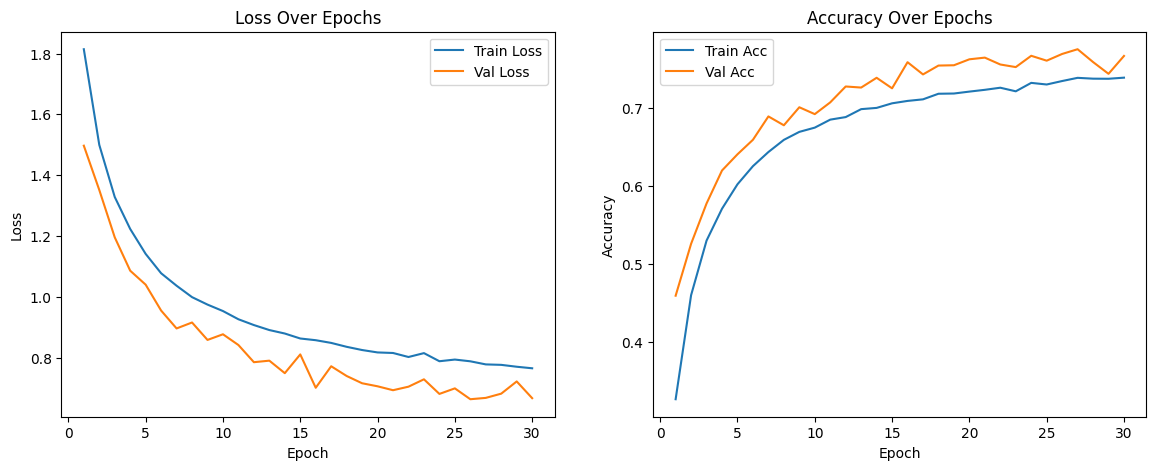

In [10]:
# Instantiate Model 1
model_1 = CNN_model(num_classes=10).to(device)

# Optimizer hyperparams (Adam)
adam_kwargs_1 = {
    "lr": 1e-3,
    "weight_decay": 5e-4  # Strong L2 regularization
}

# Train and validate
history_1 = fit(
    model_1,
    train_loader,
    val_loader,
    epochs=30,                       # 30 epochs
    optimizer_cls=torch.optim.Adam,  # Keep Adam
    optimizer_kwargs=adam_kwargs_1
)

test_loss_1, test_acc_1 = test_model(model_1, test_loader)
print(f"\nTest Loss Model 1: {test_loss_1:.4f}, Test Acc: {test_acc_1:.4f}")
plot_history(history_1)

Epoch [1/150] Train Loss: 1.8350, Train Acc: 0.3174, Val Loss: 1.5746, Val Acc: 0.4145, Time: 0:00:29.524472
Epoch [2/150] Train Loss: 1.5344, Train Acc: 0.4440, Val Loss: 1.3699, Val Acc: 0.5123, Time: 0:00:29.417128
Epoch [3/150] Train Loss: 1.3709, Train Acc: 0.5131, Val Loss: 1.2606, Val Acc: 0.5479, Time: 0:00:29.318792
Epoch [4/150] Train Loss: 1.2497, Train Acc: 0.5606, Val Loss: 1.1193, Val Acc: 0.6090, Time: 0:00:29.048406
Epoch [5/150] Train Loss: 1.1620, Train Acc: 0.5929, Val Loss: 1.0278, Val Acc: 0.6389, Time: 0:00:29.230567
Epoch [7/150] Train Loss: 1.0489, Train Acc: 0.6387, Val Loss: 0.9396, Val Acc: 0.6744, Time: 0:00:29.567080
Epoch [8/150] Train Loss: 1.0074, Train Acc: 0.6547, Val Loss: 0.9188, Val Acc: 0.6730, Time: 0:00:29.144425
Epoch [9/150] Train Loss: 0.9884, Train Acc: 0.6582, Val Loss: 0.8624, Val Acc: 0.7107, Time: 0:00:29.426229
Epoch [10/150] Train Loss: 0.9573, Train Acc: 0.6709, Val Loss: 0.8490, Val Acc: 0.6977, Time: 0:00:29.175514
Epoch [11/150] Tra

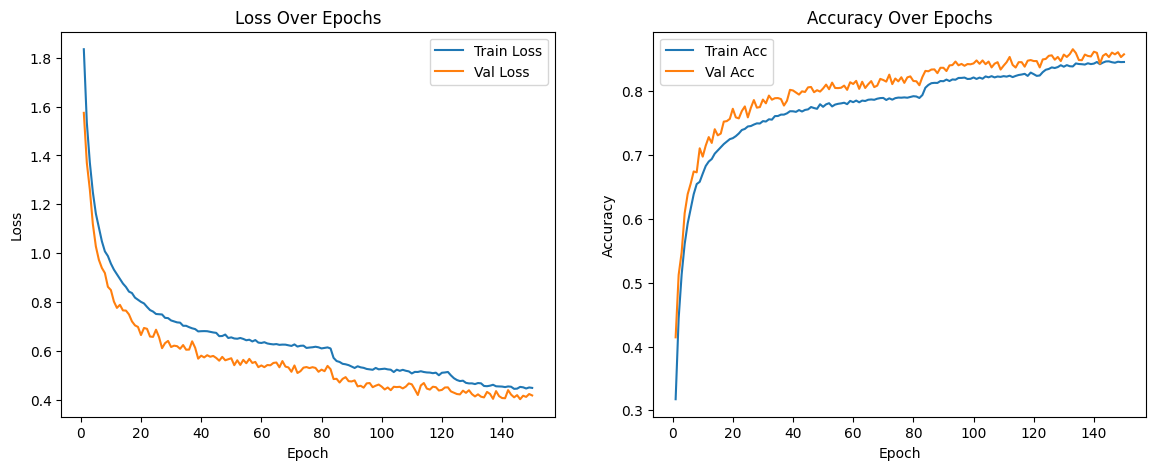

In [11]:
# Using Google colab with A100 GPU (Approximately 75 Minutes - 30 seconds each epoch):
# Test Loss: 0.2863, Test Acc: 0.9067
# 256 batch size

# Now its 128 batch size
# Instantiate your model
model_2 = CNN_model(num_classes=10).to(device)

# For example, let's use Adam with these hyperparams:
adam_kwargs_2 = {
    "lr": 0.001,
    "weight_decay": 1e-4
}

# Train with early stopping and LR scheduler
history_2 = fit(
    model_2,
    train_loader,
    val_loader,
    epochs=150,              # max 150 epochs
    patience_lr=10,          # reduce LR after 10 epochs of no improvement
    patience_es=20,          # stop after 20 epochs of no improvement
    factor=0.5,              # half the LR each time plateau is reached
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=adam_kwargs_2
)

test_loss_2, test_acc_2 = test_model(model_2, test_loader)
print(f"\nTest Loss Model 2: {test_loss_2:.4f}, Test Acc: {test_acc_2:.4f}")
plot_history(history_2)